# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import igraph as ig 
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio

In [2]:
data_processed = "../../data/processed/"
data_interim = "../../data/interim/"
data_external = "../../data/external/"
my_map = pd.read_csv(data_interim +"mondo_cui_map.csv")
dgn_mappings = pd.read_csv(data_external + "disease_mappings.tsv", sep="\t")
mondo_defs = pd.read_csv(data_interim+"mondo_definitions.csv")
dgn_attr = pd.read_csv(data_external + "disease_mappings_to_attributes.tsv", sep="\t")
dgn_edges = pd.read_csv(data_external + "curated_gene_disease_associations.tsv", sep="\t")
prime_node_data = pd.read_csv(data_interim+"primekg_exploring_node_table.csv", index_col=0)
prime_edge_data = pd.read_csv(data_interim+"primekg_exploring_graph_edge_table.csv",index_col=0).rename(columns={"relation":"edge_type"})
kg_nodes = pd.read_csv(data_external+"primekg_nodes.csv")

In [28]:
dismanet_disgenet = pd.read_csv(data_external + "dismanet_mappings_disgenet_results.tsv", sep="\t")
dismanet_mondo = pd.read_csv(data_external + "dismanet_mappings_mondo_results.tsv", sep="\t")

In [3]:
#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

# Datasets

In [4]:
dgn_map = dgn_mappings[dgn_mappings.vocabulary == "MONDO"][["diseaseId","code"]].rename(columns={"diseaseId":"CUI", "code":"mondo"}).astype({"CUI":"string","mondo":"int64"})
my_map = my_map.astype({"CUI": "string", "mondo":"int64"})
kg_enfermedades = kg_nodes[kg_nodes.node_source == "MONDO"].astype({"node_id":"int64"})
display(dgn_map)
display(my_map)

,CUI,mondo
56511,C0022661,1
56512,C0405580,4
56513,C0001623,4
56514,C1859877,5
56515,C0005129,9
...,...,...
75018,C0002792,100053
75019,C0413235,100054
75020,C0851578,100081
75021,C0175704,100082


,CUI,mondo
0,C0012634,1
1,C0405580,4
2,C0005818,9
3,C1285186,15
4,CN228161,23
...,...,...
16871,C2930802,8000014
16872,C0266427,8000017
16873,C0155502,8000018
16874,C1519711,8000023


# Comparo mapeos
Voy a ver en orden, desde mondo_id porque mi objetivo es resolver la mayor cantidad de mapeos a mondo posibles.

Intersección: el mondo_id está en ambos mapas -> resolver conflictos

dgn: el mondo_id está solo en dgn -> usar mapeo

my: el mondo_id está solo en mi mapeo -> usar mapeo

(hasta acá solo saber qué proporción hay de cada caso)

Conflictos:
El mismo mondo_id mapea a distinto cui en mi mapa y en el de dgn
Veo que hago con esto. En un principio ya pesqué un caso donde el mapeo de dgn es raro, que es kidney disease a disease or syndrome, cuando mondo tiene un identificador para esa enfermedad... por ahí esto se tenga que poner medio manual

,DisGeNET map,My Map
Total mondo mappings,18512,16876
Unique mondo mappings,12354,15620
Mondo mappings not in other map,3328,6594
Unique CUI mappings,13291,16752
CUI mappings not in other map,4807,8268


Unión de mondos: 18948 
Unión de cuis: 32372


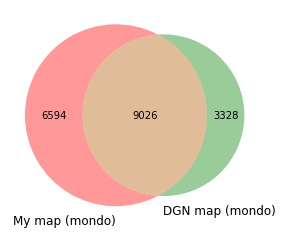

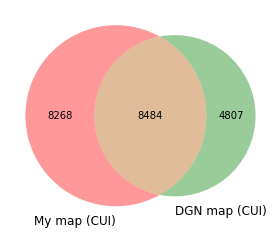

In [5]:
my_mondos = my_map.mondo.values
dgn_mondos = dgn_map.mondo.values

my_cuis = my_map.CUI.values
dgn_cuis = dgn_map.CUI.values

s_my_mondo, s_dgn_mondo = set(my_mondos), set(dgn_mondos)
s_my_cuis, s_dgn_cuis = set(my_cuis), set(dgn_cuis)

plt.figure()
v2 = venn2([s_my_mondo,s_dgn_mondo], set_labels = ["My map (mondo)", "DGN map (mondo)"])

plt.figure()
v2 = venn2([s_my_cuis,s_dgn_cuis], set_labels = ["My map (CUI)", "DGN map (CUI)"])

stats = {"DisGeNET map":{"Total mondo mappings":len(dgn_map), "Unique mondo mappings":len(s_dgn_mondo), "Mondo mappings not in other map":len(s_dgn_mondo-s_my_mondo), "Unique CUI mappings": len(s_dgn_cuis), "CUI mappings not in other map":len(s_dgn_cuis-s_my_cuis)}, "My Map":{"Total mondo mappings": len(my_map), "Unique mondo mappings":len(s_my_mondo),"Mondo mappings not in other map":len(s_my_mondo-s_dgn_mondo),"Unique CUI mappings": len(s_my_cuis), "CUI mappings not in other map":len(s_my_cuis-s_dgn_cuis)}}

display(pd.DataFrame(stats))
print(f"Unión de mondos: {len(s_my_mondo | s_dgn_mondo)} \nUnión de cuis: {len(s_my_cuis | s_my_mondo)}")

In [6]:
dgn_only = dgn_map[~dgn_map.mondo.isin(my_mondos)]
my_only = my_map[~my_map.mondo.isin(dgn_mondos)]
display(dgn_only)
display(my_only)

,CUI,mondo
56514,C1859877,5
56521,C0270327,22
56523,C0015306,24
56524,C1838049,30
56525,C2363065,44
...,...,...
75018,C0002792,100053
75019,C0413235,100054
75020,C0851578,100081
75021,C0175704,100082


,CUI,mondo
3,C1285186,15
6,CN239360,60
16,C3280646,108
26,C1621895,161
28,CN228419,170
...,...,...
16871,C2930802,8000014
16872,C0266427,8000017
16873,C0155502,8000018
16874,C1519711,8000023


## Conflictos (mondo)

In [7]:
my_shared = my_map[my_map.mondo.isin(dgn_mondos)]
dgn_shared = dgn_map[dgn_map.mondo.isin(my_mondos)]

todos = pd.merge(my_shared, dgn_shared, left_on="mondo", right_on="mondo", how="inner").rename(columns={"CUI_x":"CUI_my","CUI_y":"CUI_dgn"})
conflictos = todos[todos.CUI_my != todos.CUI_dgn]
iguales = todos[todos.CUI_my == todos.CUI_dgn]
print(f"Mapeos que coinciden: {len(iguales.mondo.unique())} \nMapeos en conflicto: {len(conflictos.mondo.unique())}")

Mapeos que coinciden: 8149 
Mapeos en conflicto: 3224


In [8]:
conflictos

,CUI_my,mondo,CUI_dgn
0,C0012634,1,C0022661
2,C0405580,4,C0001623
3,C0005818,9,C0005129
4,C0005818,9,C3278148
6,C0005818,9,C2713537
...,...,...,...
15527,CN248517,60720,C4693905
15528,CN248527,60724,C4747891
15529,CN248523,60729,C4693947
15530,CN248526,60733,C4747940


Ids con conflicto que tienen ids con "N", que no estoy encontrando en la database de umls. En este caso puedo usar el mapeo de dgn

In [9]:
conflictos[conflictos.CUI_my.apply(lambda x: "N" in x)]

,CUI_my,mondo,CUI_dgn
9,CN228161,23,C3809522
10,CN228622,49,C1835828
11,CN357508,65,C2676832
16,CN239267,90,C1834846
21,CN160484,107,C4551996
...,...,...,...
15527,CN248517,60720,C4693905
15528,CN248527,60724,C4747891
15529,CN248523,60729,C4693947
15530,CN248526,60733,C4747940


In [10]:
display(dgn_mappings[dgn_mappings.code == "0000001"])
display(my_map[my_map.CUI == "C0022661"])
display(dgn_mappings[(dgn_mappings.diseaseId == "C0022661") & (dgn_mappings.vocabulary == "MONDO")])
display(mondo_defs[mondo_defs.id == 5300])

,diseaseId,name,vocabulary,code,vocabularyName
56511,C0022661,"Kidney Failure, Chronic",MONDO,0000001,disease or disorder


,CUI,mondo
3739,C0022661,5300


,diseaseId,name,vocabulary,code,vocabularyName
56511,C0022661,"Kidney Failure, Chronic",MONDO,0000001,disease or disorder
58548,C0022661,"Kidney Failure, Chronic",MONDO,0004375,end stage renal failure
59273,C0022661,"Kidney Failure, Chronic",MONDO,0005300,chronic kidney disease
74083,C0022661,"Kidney Failure, Chronic",MONDO,0024327,chronic renal failure syndrome


,id,name,definition
3854,5300,chronic kidney disease,Impairment of the renal function secondary to ...


In [11]:
dgn_mappings[(dgn_mappings.diseaseId.isin(conflictos.CUI_dgn)) & (dgn_mappings.vocabulary == "MONDO")]

,diseaseId,name,vocabulary,code,vocabularyName
56511,C0022661,"Kidney Failure, Chronic",MONDO,0000001,disease or disorder
56513,C0001623,Adrenal gland hypofunction,MONDO,0000004,adrenocortical insufficiency
56514,C1859877,Alopecia universalis congenita,MONDO,0000005,"alopecia, isolated"
56515,C0005129,Bernard-Soulier Syndrome,MONDO,0000009,"inherited bleeding disorder, platelet-type"
56516,C3278148,"BERNARD-SOULIER SYNDROME, TYPE A1",MONDO,0000009,"inherited bleeding disorder, platelet-type"
...,...,...,...,...,...
75009,C0341703,Adult Fanconi syndrome,MONDO,0060778,adult Fanconi syndrome
75012,C0024899,Mastocytosis,MONDO,0100004,mast cell activation syndrome
75013,C1568272,Tendinopathy,MONDO,0100010,tendinopathy
75021,C0175704,LEOPARD Syndrome,MONDO,0100082,LEOPARD syndrome 1


In [12]:
mondo_defs

,id,name,definition
0,1,disease or disorder,A disease is a disposition to undergo patholog...
1,4,adrenocortical insufficiency,An endocrine or hormonal disorder that occurs ...
2,15,classic complement early component deficiency,A genetic deficiency of any early component of...
3,22,nocturnal enuresis,Urination during sleep.
4,44,hereditary hypophosphatemic rickets,Hypophosphatemic rickets is a group of genetic...
...,...,...,...
15856,8000015,"46,XY sex reversal 11","Any 46,XY complete gonadal dysgenesis in which..."
15857,8000017,testicular regression syndrome,A developmental anomaly characterized by the a...
15858,8000018,benign paroxysmal positional vertigo,Idiopathic recurrent vertigo associated with p...
15859,8000023,type 3 autoimmune lymphoproliferative syndrome,"A rare, primary immunodeficiency. It is caused..."


# Hago mapeo maximizando cobertura de CUI

Objetivo:

Maximizar el número de nodos en disgenet con un CUI mapeado a MONDO. Con prioridad: 11000 nodos del dataset curado máxima prioridad, después el resto. También es prioridad tener mapeo hacia los nodos enfermedad que están en pkg y no cualquier mondo.

Quiero ver si cambia algo, porque la vez anterior lo hice con un approach "maximizar mondos que mapean a cui" y como el mapeo no es 1:1, esto por ahí no es lo mismo.

In [13]:
pkg_edges_enfermedades = prime_edge_data[prime_edge_data.edge_type == "disease_disease"]
pkg_nodos_enfermedades = prime_node_data[prime_node_data.node_type == "disease"]

In [14]:
all_dgn_nodes = pd.unique(dgn_attr.diseaseId)
curated_dgn_nodes = pd.unique(dgn_edges.diseaseId)

In [15]:
dgn_enfermedades_curado = dgn_edges[["diseaseId","diseaseName","diseaseType"]].drop_duplicates()
dgn_enfermedades_all = dgn_attr[["diseaseId","name","type"]].drop_duplicates()

Los mapeos que solo están en un mapa o el otro los voy a usar directamente

In [16]:
mapeos = []
dgn_only = dgn_map[~dgn_map.CUI.isin(my_cuis)]
my_only = my_map[~my_map.CUI.isin(dgn_cuis)]

mapeos.append(dgn_only)
mapeos.append(my_only)

Veo los compartidos

In [17]:
my_shared = my_map[my_map.CUI.isin(dgn_cuis)]
dgn_shared = dgn_map[dgn_map.CUI.isin(my_cuis)]

todos = pd.merge(my_shared, dgn_shared, left_on="CUI", right_on="CUI", how="inner").rename(columns={"mondo_x":"mondo_my","mondo_y":"mondo_dgn"})
conflictos = todos[todos.mondo_my != todos.mondo_dgn]
iguales = todos[todos.mondo_my == todos.mondo_dgn]
print(f"Mapeos que coinciden: {len(iguales.CUI.unique())} \nMapeos en conflicto: {len(conflictos.CUI.unique())}")
mapeos.append(iguales[["CUI","mondo_my"]].rename(columns={"mondo_my":"mondo"}))

Mapeos que coinciden: 8396 
Mapeos en conflicto: 1350


In [18]:
conflictos

,CUI,mondo_my,mondo_dgn
2,C0005818,9,2245
4,C0687154,78,10822
5,C0687154,78,13638
6,C0687154,78,13641
7,C0687154,78,14296
...,...,...,...
11046,C4310735,8000013,44631
11047,C2930802,8000014,7140
11048,C0266427,8000017,10107
11049,C0155502,8000018,8656


Por ahí puedo resolver conflictos en base a qué nodo está en primekg

In [19]:
primekg_enfermedades = prime_node_data[prime_node_data.node_source == "MONDO"].astype({"node_id":"int64"})
my_in_prime = conflictos[conflictos.mondo_my.isin(primekg_enfermedades.node_id)]
dgn_in_prime = conflictos[conflictos.mondo_dgn.isin(primekg_enfermedades.node_id)]
print(f"Nodos de mi mapeo en primekg = {len(my_in_prime)} \nNodos del mapeo de disgenet en primekg = {len(dgn_in_prime)}")

Nodos de mi mapeo en primekg = 1111 
Nodos del mapeo de disgenet en primekg = 858


In [20]:
conflictos.loc[:,"my_in"] = conflictos.mondo_my.isin(primekg_enfermedades.node_id)
conflictos.loc[:,"dgn_in"] = conflictos.mondo_dgn.isin(primekg_enfermedades.node_id)

/tmp/ipykernel_108061/3082971227.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conflictos.loc[:,"my_in"] = conflictos.mondo_my.isin(primekg_enfermedades.node_id)
/tmp/ipykernel_108061/3082971227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conflictos.loc[:,"dgn_in"] = conflictos.mondo_dgn.isin(primekg_enfermedades.node_id)


In [21]:
aver = pd.concat(mapeos)

In [22]:
aver

,CUI,mondo
56513,C0001623,4
56514,C1859877,5
56516,C3278148,9
56518,C2713537,9
56519,C1856448,9
...,...,...
10993,C4540520,60627
10994,C0341702,60779
10995,C4329672,60783
10996,C3203657,100014


In [23]:
kg_enfermedades

,node_index,node_id,node_type,node_name,node_source
27165,27165,8019,disease,mullerian aplasia and hyperandrogenism,MONDO
27166,27166,11043,disease,"myelodysplasia, immunodeficiency, facial dysmo...",MONDO
27168,27168,8878,disease,"bone dysplasia, lethal Holmgren type",MONDO
27169,27169,8905,disease,predisposition to invasive fungal disease due ...,MONDO
27171,27171,7162,disease,asymmetric short stature syndrome,MONDO
...,...,...,...,...,...
100023,100023,400000,disease,small intestinal bacterial overgrowth,MONDO
100024,100024,400002,disease,calcium-alkali syndrome,MONDO
100025,100025,400003,disease,skeletal fluorosis,MONDO
100026,100026,400004,disease,phrynoderma,MONDO


# Trato de organizar todo esto D:

Primero veo para los dos mapeos que tengo, que tantos ids están en primekg

In [24]:
dgn_en_kg = dgn_map[dgn_map.mondo.isin(kg_enfermedades.node_id)]
my_en_kg = my_map[my_map.mondo.isin(kg_enfermedades.node_id)]
display(pd.DataFrame({"My Map":{"mondo ids in prime kg":len(my_en_kg), "mondo ids not in prime kg":len(my_map) - len(my_en_kg)}, "DisGeNET map": {"mondo ids in prime kg":len(dgn_en_kg),"mondo ids not in prime kg":len(dgn_map) - len(dgn_en_kg)}}))

,My Map,DisGeNET map
mondo ids in prime kg,11882,9833
mondo ids not in prime kg,4994,8679


# AVER